## Preliminary estimates of intensity, heating rate for grant

In [2]:
import numpy as np
import sys
from math import *

import matplotlib.pyplot as plt
from matplotlib import collections
from matplotlib import image

%matplotlib inline

sys.path.append('C:\\Users\\vchaplin\\Documents\\HiFU\code\\myPy')  
sys.path.append('C:\\Users\\Vandiver\\Documents\\HiFU\\code\\CUDA\\RSgpu\\Release')

import geom
import transducers
import sonalleve
import RSgpuPySwig

import PBHE_CUDA
import sys
sys.path.append('C:\\Users\\vchaplin\\Documents\\HiFU\\code\\AblationSims')
import ablation_utils
import importlib

In [200]:
f0=5e5
c0=1540
rho=1040
Cp=4100
ktherm=0.5

Ispta0=1.0e7

T0=37
k0 = 2*pi*f0/c0

xw=2.0
yw=2.0
zmin=3.0
zmax=9.01

Nt=10
Nx=64
Ny=64
Nz=94

dataType = np.float32

simgrid = ablation_utils.makeSimPhysGrid(nt=Nt,nx=Nx,ny=Ny,nz=Nz,rho=rho,ktherm=ktherm,f0=f0,Cp=Cp,c0=c0,
    dt=0.1, xr=[-xw/2.0, xw/2.0], yr=[-yw/2.0, yw/2.0],zr=[zmin,zmax])


CEMfinal =np.zeros([Nx,Ny,Nz],dtype=dataType)
Rbase=np.zeros([Nx,Ny,Nz],dtype=dataType)
Tmax=np.zeros([Nx,Ny,Nz],dtype=dataType)

[T4d,tdot3d,kt3d,rhoCp3d,Dtxyz]=[simgrid[k] for k in tuple('T,Tdot,kt,rhoCp,dtxyz'.split(','))]

[xrp,yrp,zrp]=[simgrid[k] for k in tuple('xrp,yrp,zrp'.split(','))]
(dt,dx,dy,dz)=simgrid['dtxyz']

gxp,gyp,gzp = np.meshgrid(xrp, yrp, zrp, sparse=False, indexing='ij')
calcGridDist= lambda rr: np.sqrt((gxp-rr[0])**2 + (gyp-rr[1])**2 + (gzp-rr[2])**2)

zplane=0.0254*2
focplaneZpix=np.where(np.logical_and( (zrp[1:-1]-zplane>=0) , (zrp[0:-2]-zplane<=0) ))[0][0]

gxp,gyp,gzp = np.meshgrid(xrp, yrp, zrp, sparse=False, indexing='ij')
calcGridDist= lambda rr: np.sqrt((gxp-rr[0])**2 + (gyp-rr[1])**2 + (gzp-rr[2])**2)


voxml = dx*dy*dz*1e6

In [202]:
simgrid['dtxyz']

array([ 0.1       ,  0.00031746,  0.00031746,  0.00064624], dtype=float32)

In [203]:
def L2norm(arg):
    return np.sqrt(np.sum(np.abs(arg)**2))

rfoc=2.54*2/100.0
(uxyz,nn)=transducers.new_stipled_spherecap_array(rfoc, 2.54/100, 100)

unvecs = np.apply_along_axis(lambda x: x / np.sqrt(np.sum(x**2)), 1, [0.0,0.0,rfoc] - uxyz )

uamp0 = np.ones(nn) / nn

RSkeys=dict(ROC=rfoc)


P0 = transducers.calc_pressure_field_cuda(k0, uxyz, unvecs, uamp0, xrp, yrp, zrp)

I0 = np.abs(P0)**2 / (2.0*rho*c0)
#powerRenormL1 = (Ispta0/np.max(I0))

Ispta0=5.6e4*.15

calibrationGain = (Ispta0/np.max(I0))
L2powRenorm = sqrt(calibrationGain)*L2norm(uamp0)

uamp0 *= L2powRenorm/L2norm(uamp0)
P0 = transducers.calc_pressure_field_cuda(k0, uxyz, unvecs, uamp0, xrp, yrp, zrp)
I0 = np.abs(P0)**2 / (2.0*rho*c0)

In [181]:
zzz=np.arange(0.03,0.09001,0.001)
Pz = transducers.calc_pressure_profile_cuda(k0, uxyz, unvecs, uamp0, np.zeros_like(zzz), np.zeros_like(zzz), zzz)

(3, 9)

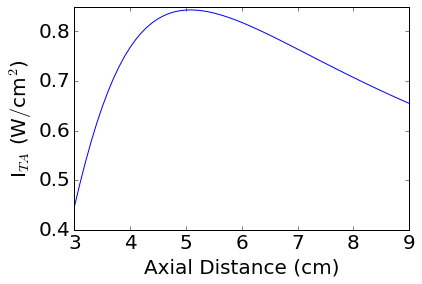

In [187]:
plt.plot(zzz*100,np.abs(Pz)**2/(2.0*rho*c0)/1e4 )
plt.xlabel('Axial Distance (cm)', fontsize=20)
plt.ylabel('I$_{TA}$ (W$/$cm$^2$)', fontsize=20)
plt.gca().tick_params(labelsize=20)
plt.xlim([3,9])

In [221]:
simgrid['T'][0] = 37.0
CEMfinal[:]=0
interpTimes = np.arange(0.0,40.01, 1.0)
interpTemp = np.zeros([len(interpTimes)])
tightROI =geom.inCuboidBounds(gxp,gyp,gzp, xr=[-0.0075, 0.0075], yr=[-0.0075, 0.0075], zr=[rfoc-0.005, rfoc+0.005])   

pbheDict = {'GPU':False,'perfRate':0.0, 'Freeflow':1, 'interpTimes':interpTimes, 'interpolatedTemp': interpTemp, 'interpFunc':np.max, 'interpmask':None}


ablation_utils.sonicate4D(simgrid,interpTimes[0:-1],interpTimes[1:],uamp0, uxyz, unvecs, use_gpu=True, CEM=CEMfinal, verbose=True, 
                          PBkeys=pbheDict,alpha_acc=3.45);

 40/ 40, 100% 

In [ ]:
ablation_utils.calc_heating

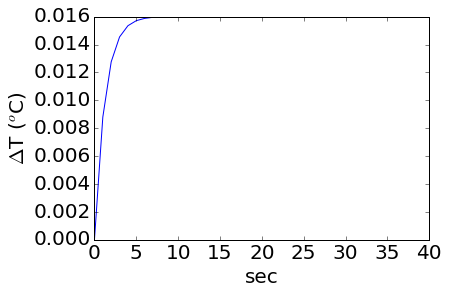

In [217]:
plt.plot(interpTimes,interpTemp-37)

plt.xlabel('sec', fontsize=20)
plt.ylabel('$\Delta$T ($^o$C)', fontsize=20)
plt.gca().tick_params(labelsize=20)

In [209]:
(interpTemp[-1]-interpTemp[0])/interpTimes[-1]

0.0091789245605468743

(3.0, 9.0100002)

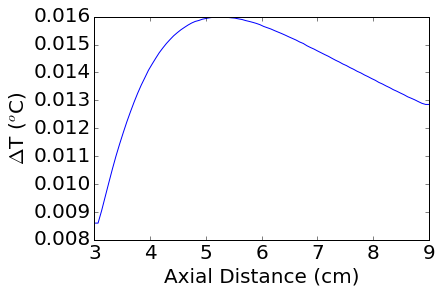

In [218]:
plt.plot(zrp*100,simgrid['T'][0,32,32,:]-37)
plt.xlabel('Axial Distance (cm)', fontsize=20)
plt.ylabel('$\Delta$T ($^o$C)', fontsize=20)
plt.gca().tick_params(labelsize=20)
plt.xlim(100*zrp[[0,-1]])

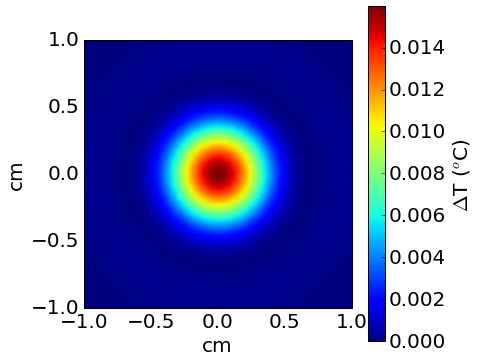

In [219]:
plt.figure(figsize=(6,6))

plt.imshow(simgrid['T'][0,:,:,focplaneZpix]-37,extent=[100*yrp[0],100*yrp[-1],100*xrp[0],100*xrp[-1]])
cb=plt.colorbar(orientation='vertical')
cb.set_label('$\Delta$T ($^o$C)',fontsize=20)
cb.ax.tick_params(labelsize=20)

plt.xlabel('cm', fontsize=20)
plt.ylabel('cm', fontsize=20)
plt.gca().tick_params(labelsize=20)

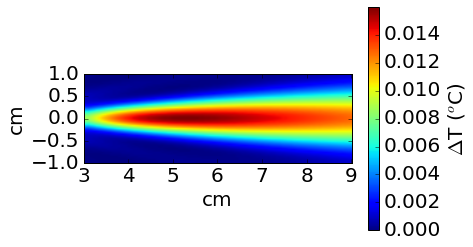

In [220]:
plt.imshow(simgrid['T'][0,32,:,:] - 37,extent=[100*zrp[0],100*zrp[-1],100*yrp[0],100*yrp[-1]])
cb=plt.colorbar(orientation='vertical')
cb.set_label('$\Delta$T ($^o$C)',fontsize=20)
cb.ax.tick_params(labelsize=20)

plt.xlabel('cm', fontsize=20)
plt.ylabel('cm', fontsize=20)
plt.gca().tick_params(labelsize=20)

In [105]:
0.3/8.68

0.03456221198156682